In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
from highlight_text import fig_text
import pandas as pd

from PIL import Image
import urllib
import os

In [106]:
# df = pd.read_csv('../../data/soc/ligue1_shots.csv', index_col=0)
df = pd.read_csv('../../data/shots/epl_shots_2223.csv', index_col=0)
df['min'] = df['min'].astype(int)
df['xG'] = df['xG'].astype(float)

df = df.replace({
    'teamName': {
        'Paris Saint-Germain': 'PSG'
    }
})

match_id = 3900943

Text(0.02, 1.05, 'Aston Villa (2.3) vs. Everton (1.6): 2 - 1')

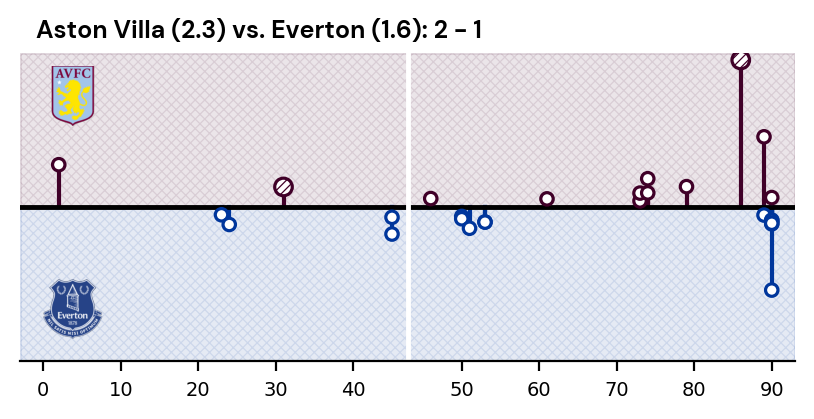

In [107]:
match_df = df[df['match_id']==match_id].reset_index(drop=True)
match_df = match_df.sort_values(by='min',ascending=True).reset_index(drop=True)

home_conditional = (match_df['venue']=='H')
away_conditional = (match_df['venue']=='A')

fig = plt.figure(figsize=(5,2),dpi=200)
ax = plt.subplot(111)

ax.set_ylim(-1.05,1.05)
ax.set_xlim(-5, 95)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks([])
ax.xaxis.set_ticks(
    [x for x in range(-2,45,10)] + [x for x in range(52,102,10)],
    labels=[x for x in range(0,91,10)]
)
ax.tick_params(labelsize=7)

plt.rcParams['hatch.linewidth'] = .45

home_color = match_df[home_conditional]['teamColor'].iloc[0]
away_color = match_df[away_conditional]['teamColor'].iloc[0]

for index,shot in enumerate(match_df[home_conditional]['xG']):
    ec_ = home_color
    marker = 'o'
    minute = match_df[home_conditional]['min'].iloc[index]
    if minute < 46:
        offset_x = -2
    else:
        offset_x = 2
    if match_df[home_conditional]['eventType'].iloc[index] != 'Goal':
        hatch = ''
        ax.scatter([minute + offset_x],[shot + .025],marker=marker,s=20,hatch=hatch,color='white',zorder=3,lw=1.15,ec=ec_)
    else:
        hatch = '////////'
        marker = 'o'
        if match_df[home_conditional]['isOwnGoal'].iloc[index]:
            shot = -1*shot
            ec_=away_color
            marker = '^'
        ax.scatter([minute+offset_x],[shot+.025],marker=marker,s=40,hatch=hatch,color='white',zorder=4,lw=1.15,ec=ec_)
    ax.plot([minute + offset_x,minute+offset_x],[0,shot],color=ec_,zorder=2)
    
for index,shot in enumerate(match_df[away_conditional]['xG']):
    ec_ = away_color
    marker = 'o'
    minute = match_df[away_conditional]['min'].iloc[index]
    if minute < 46:
        offset_x = -2
    else:
        offset_x = 2
    if match_df[away_conditional]['eventType'].iloc[index] != 'Goal':
        hatch = ''
        ax.scatter([minute + offset_x], [-1*shot - .025], marker=marker, s=20, hatch=hatch, 
            color="white", zorder=3, lw=1.15, ec=ec_)
    else:
        hatch = '/////////////'
        marker = 'o'
        if match_df[away_conditional]['isOwnGoal'].iloc[index]:
            shot = -1*shot
            ec_ = home_color
            marker = 'v'
        ax.scatter([minute + offset_x], [-1*shot - .025], marker=marker, s=40, hatch=hatch, 
                color="white", zorder=4, lw=1.15, ec=ec_)
    ax.plot([minute + offset_x, minute + offset_x], [0, -1*shot], color=ec_, zorder=2)

ax.plot([-5,95],[0,0],color='black',lw=1.75)
ax.plot([45,45],[-1.05,1.05],color = 'white',lw=1.75,zorder=2)
ax.fill_between(
    x=[-5,95],y1=[0],y2=[1.05],
    color=home_color,alpha=.1,zorder=1,
    hatch='xxxxxxx'
)
ax.fill_between(
    x=[-5,95],y1=[0],y2=[-1.05],
    color=away_color,alpha=.1,zorder=1,
    hatch='xxxxxxx'
)
# *+-./OX\ox|
home_team_id = match_df[home_conditional]['teamId'].iloc[0]
away_team_id = match_df[away_conditional]['teamId'].iloc[0]
home_team_name = match_df[home_conditional]['teamName'].iloc[0]
away_team_name = match_df[away_conditional]['teamName'].iloc[0]

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'

ax_coords = DC_to_NFC([-2, .55])
logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.15, 0.15], anchor = 'W')
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{home_team_id:.0f}.png'))
logo_ax.imshow(club_icon)
logo_ax.axis('off')

ax_coords = DC_to_NFC([-2, -.9])
logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.15, 0.15], anchor = 'W')
club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{away_team_id:.0f}.png'))
logo_ax.imshow(club_icon)
logo_ax.axis('off')

home_xG = match_df[home_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
away_xG = match_df[away_conditional & (match_df['isOwnGoal'] == False)]['xG'].sum()
home_goals = (match_df[home_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (match_df[away_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()
away_goals = (match_df[away_conditional & (match_df['isOwnGoal'] == False)]['eventType'] == 'Goal').sum() + (match_df[home_conditional & (match_df['isOwnGoal'] == True)]['eventType'] == 'Goal').sum()

ax.annotate(
    xy=(0.02, 1.05),
    text=f'{home_team_name} ({home_xG:.1f}) vs. {away_team_name} ({away_xG:.1f}): {home_goals} - {away_goals}',
    xycoords='axes fraction',
    weight='bold',
    size=9,font = "DM Sans"
    )